In [6]:
import torch

In [7]:
from datasets import HumanPosesDataset, HumanPosesDatasetFromFiles

In [8]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd

TRAIN_DIR = Path('human_poses_data/img_train')
CSV_PATH = Path('human_poses_data/train_answers.csv')

df = pd.read_csv(CSV_PATH)

df = df.rename(columns={"target_feature": "target"})

df['img_path'] = df['img_id'].apply(lambda x: TRAIN_DIR / f"{x}.jpg")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['target'],
    random_state=42
)

train_files = train_df['img_path'].tolist()
val_files = val_df['img_path'].tolist()

train_labels = train_df['target'].tolist()
val_labels = val_df['target'].tolist()

In [9]:
train_dataset = HumanPosesDatasetFromFiles(train_files, train_labels, mode='train')
val_dataset = HumanPosesDatasetFromFiles(val_files, val_labels, mode='val')

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
NUM_WORKERS = 4

loader_kwargs = dict(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
)

train_loader = DataLoader(train_dataset, shuffle=True, **loader_kwargs)
val_loader = DataLoader(val_dataset,   shuffle=False, **loader_kwargs)

In [5]:
pd.Series(train_labels).value_counts().sort_index()

0     2009
1      108
2      424
3     1344
4      602
5      786
6      640
8      426
9      978
10     312
11     422
12     375
13     354
14     182
16     602
18     328
Name: count, dtype: int64

# Обучение

In [11]:
device = torch.device("mps" if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_f1s, test_f1s):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='val')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()

    axs[1].plot(range(1, len(train_f1s) + 1), train_f1s, label='train')
    axs[1].plot(range(1, len(test_f1s) + 1), test_f1s, label='val')
    axs[1].set_title("Macro F1-score per Epoch")
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('F1-score')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [13]:
from sklearn.metrics import f1_score

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    all_preds, all_labels = [], []
    model.train()

    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        all_preds.append(logits.argmax(dim=1).cpu())
        all_labels.append(labels.cpu())

    train_loss /= len(train_loader.dataset)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    return train_loss, train_f1


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss = 0.0
    all_preds, all_labels = [], []
    model.eval()

    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        all_preds.append(logits.argmax(dim=1).cpu())
        all_labels.append(labels.cpu())

    test_loss /= len(test_loader.dataset)
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    test_f1 = f1_score(all_labels, all_preds, average='macro')
    return test_loss, test_f1


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, test_losses = [], []
    train_f1s, test_f1s = [], []

    best_f1 = 0.0

    for epoch in range(1, num_epochs + 1):
        train_loss, train_f1 = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_f1 = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        if test_f1 > best_f1:
            best_f1 = test_f1
            torch.save(model.state_dict(), 'best_model_by_f1.pth')

        train_losses.append(train_loss)
        train_f1s.append(train_f1)
        test_losses.append(test_loss)
        test_f1s.append(test_f1)

        plot_losses(train_losses, test_losses, train_f1s, test_f1s)

    return train_losses, test_losses, train_f1s, test_f1s

In [14]:
def save_checkpoint(model, optimizer, scheduler, epoch, path="checkpoint.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'epoch': epoch
    }, path)
    print(f"Чекпойнт сохранён в {path}")


In [15]:
def load_checkpoint(model, optimizer=None, scheduler=None, path="checkpoint.pth", device="cpu"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    start_epoch = checkpoint.get('epoch', 0)
    print(f"Загружен чекпойнт из {path}, начиная с эпохи {start_epoch + 1}")
    return start_epoch

# Модели

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNetLike(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)

        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flatten_dim = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
n_classes = len(set(train_labels))
num_epochs = 10
model = LeNetLike(n_classes).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_epochs=num_epochs
)

Training 1/10:  18%|█▊        | 28/155 [00:13<01:00,  2.09it/s]


KeyboardInterrupt: 

# Предикт

In [17]:
import os
import pandas as pd

test_dir = Path("human_poses_data/img_test")
test_files = sorted(os.listdir(test_dir), key=lambda x: int(x.split(".")[0]))

test_df = pd.DataFrame({
    "img_id": test_files
})

test_df.to_csv("human_poses_data/test_dummy.csv", index=False)


In [18]:
test_dataset = HumanPosesDataset(
    csv_path="human_poses_data/test_dummy.csv",
    img_dir="human_poses_data/img_test",
    mode='test'
)

test_loader = DataLoader(test_dataset, shuffle=False, **loader_kwargs)

In [19]:
@torch.no_grad()
def predict(model, dataloader, device):
    model.eval()
    all_preds, all_ids = [], []

    for images, img_names in tqdm(dataloader, desc="Predicting"):
        images = images.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_ids.extend(img_names)

    return all_ids, all_preds


In [24]:
img_ids, predictions = predict(model, test_loader, device)

ids = [int(name.split('.')[0]) for name in img_ids]

submission = pd.DataFrame({
    "id": ids,
    "target_feature": predictions
}).sort_values("id")

submission.to_csv("submission.csv", index=False)

Predicting: 100%|██████████| 83/83 [00:15<00:00,  5.37it/s]


# MobileNet v2 (даже не из коробки, честно переписывал сидел)!

![ыыыы](./mobilev2.jpg)

In [21]:
import torch
from MobileNetV2 import MobileNetV2

num_classes = 19

model = MobileNetV2(n_class=num_classes).to(device)

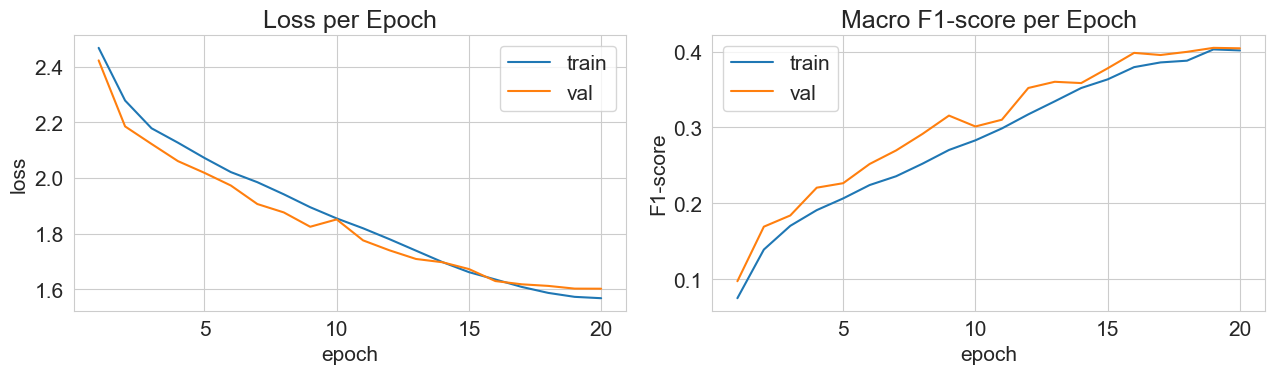

([2.468194044219594,
  2.278622085056081,
  2.1787822507818944,
  2.1268661735128207,
  2.072104858764019,
  2.02109218236651,
  1.9848280868885058,
  1.9413029271197908,
  1.894734797331181,
  1.8544661018272859,
  1.818918129619779,
  1.7796620510389,
  1.738471809785182,
  1.6973312543656147,
  1.661216634080519,
  1.634812123998186,
  1.60794614815201,
  1.5864825985762352,
  1.5722383679140448,
  1.5673865785108998],
 [2.423045615178496,
  2.1855015538831633,
  2.1223929744626404,
  2.0605539177923116,
  2.018498515735833,
  1.9727962217508253,
  1.906276088909652,
  1.8760872820065497,
  1.8245023800272469,
  1.8509172760100738,
  1.7754163293946434,
  1.7395715497632902,
  1.7085645147746094,
  1.6967618334360823,
  1.672314708523916,
  1.6290859514990446,
  1.6173716240962281,
  1.611664797764395,
  1.6018485317523188,
  1.6015675971849175],
 [0.07468941099698993,
  0.13885027842777958,
  0.17018125190865302,
  0.19091118622262165,
  0.20637503891171127,
  0.22400482670852498,


In [19]:
num_epochs = 20

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_epochs=num_epochs
)

In [20]:
save_checkpoint(model, optimizer, scheduler, epoch=20, path="mobilenetv2_epoch20.pth")

Чекпойнт сохранён в mobilenetv2_epoch20.pth


In [25]:
img_ids, predictions = predict(model, test_loader, device)

ids = [int(name.split('.')[0]) for name in img_ids]

submission = pd.DataFrame({
    "id": ids,
    "target_feature": predictions
}).sort_values("id")

submission.to_csv("submission.csv", index=False)

Predicting: 100%|██████████| 83/83 [00:23<00:00,  3.57it/s]


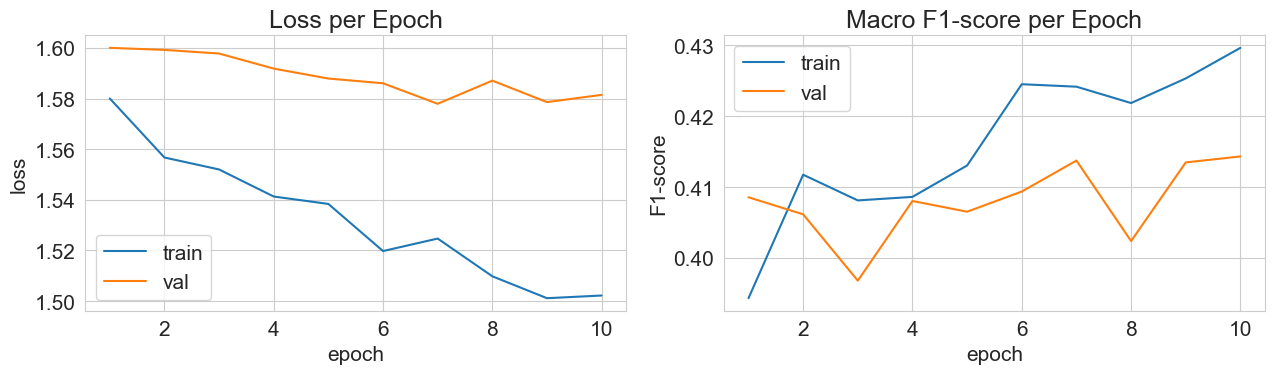

In [27]:
num_epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses, val_losses, train_f1s, val_f1s = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_epochs=num_epochs
)

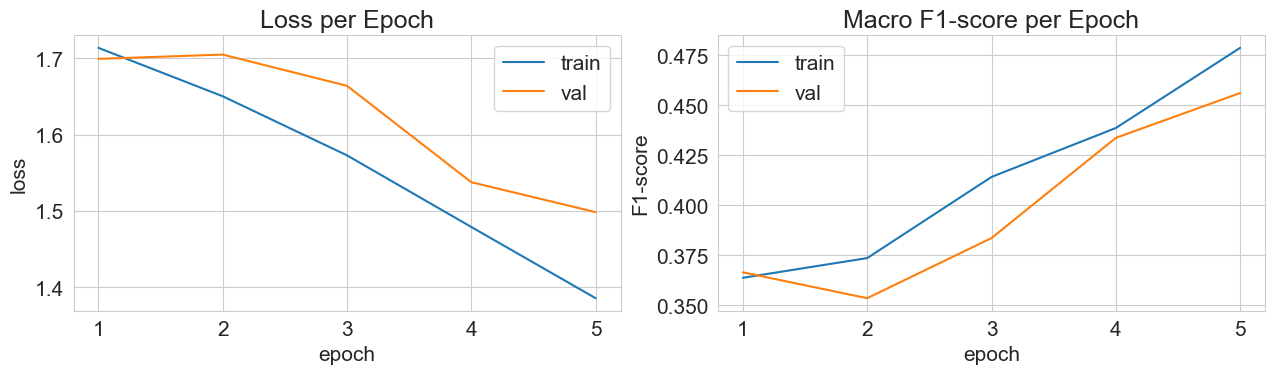

In [29]:
num_epochs = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses, val_losses, train_f1s, val_f1s = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_epochs=num_epochs
)

In [30]:
img_ids, predictions = predict(model, test_loader, device)

ids = [int(name.split('.')[0]) for name in img_ids]

submission = pd.DataFrame({
    "id": ids,
    "target_feature": predictions
}).sort_values("id")

submission.to_csv("submission.csv", index=False)

Predicting: 100%|██████████| 83/83 [00:19<00:00,  4.22it/s]


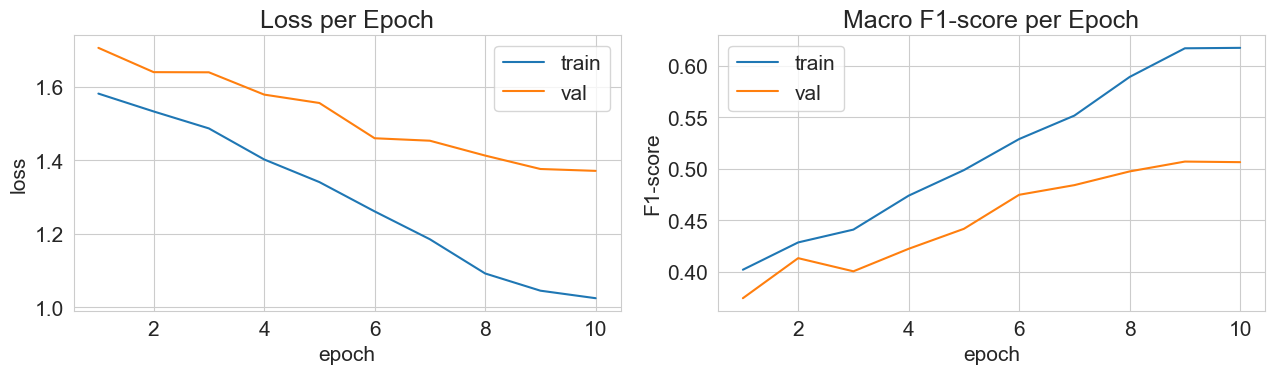

In [32]:
num_epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses, val_losses, train_f1s, val_f1s = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_epochs=num_epochs
)

In [33]:
img_ids, predictions = predict(model, test_loader, device)

ids = [int(name.split('.')[0]) for name in img_ids]

submission = pd.DataFrame({
    "id": ids,
    "target_feature": predictions
}).sort_values("id")

submission.to_csv("submission.csv", index=False)

Predicting: 100%|██████████| 83/83 [00:19<00:00,  4.36it/s]


In [34]:
!kaggle competitions submit -c ml-intensive-yandex-academy-spring-2025 -f submission.csv -m "Message"

100%|██████████████████████████████████████| 39.5k/39.5k [00:00<00:00, 54.9kB/s]
Successfully submitted to ML intensive Yandex Academy spring 2025

In [22]:
model = MobileNetV2(n_class=19).to(device)  

In [23]:
model.load_state_dict(torch.load("best_model_by_f1.pth", map_location=device))
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [24]:
model.load_state_dict(torch.load("best_model_by_f1.pth", map_location=device))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

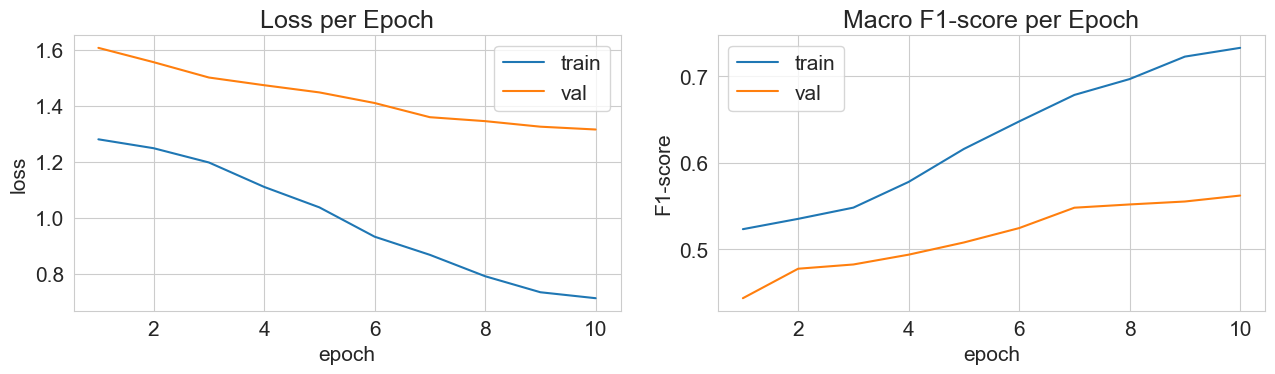

In [25]:
num_epochs = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses, val_losses, train_f1s, val_f1s = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_epochs=num_epochs
)

In [26]:
img_ids, predictions = predict(model, test_loader, device)

ids = [int(name.split('.')[0]) for name in img_ids]

submission = pd.DataFrame({
    "id": ids,
    "target_feature": predictions
}).sort_values("id")

submission.to_csv("submission.csv", index=False)

Predicting: 100%|██████████| 83/83 [00:22<00:00,  3.68it/s]


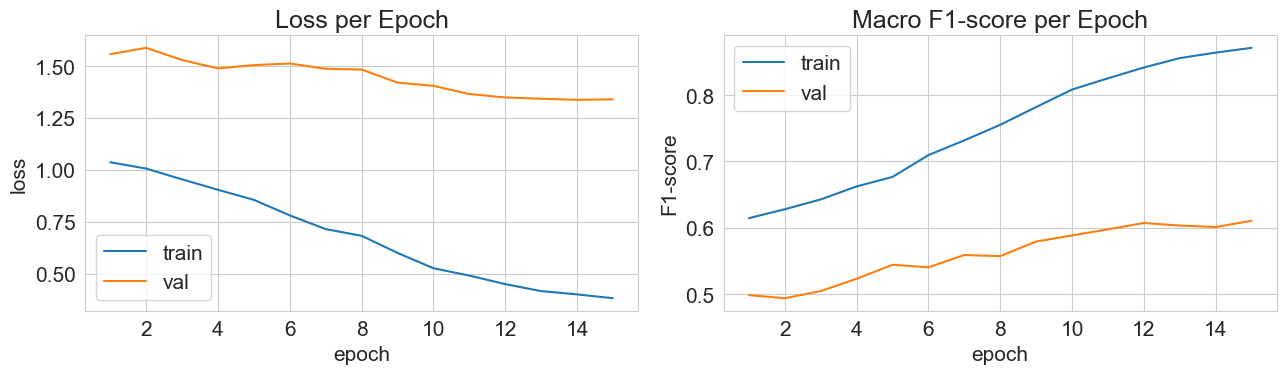

In [28]:
num_epochs = 15

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses, val_losses, train_f1s, val_f1s = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_epochs=num_epochs
)

In [29]:
img_ids, predictions = predict(model, test_loader, device)

ids = [int(name.split('.')[0]) for name in img_ids]

submission = pd.DataFrame({
    "id": ids,
    "target_feature": predictions
}).sort_values("id")

submission.to_csv("submission.csv", index=False)

Predicting: 100%|██████████| 83/83 [00:19<00:00,  4.34it/s]


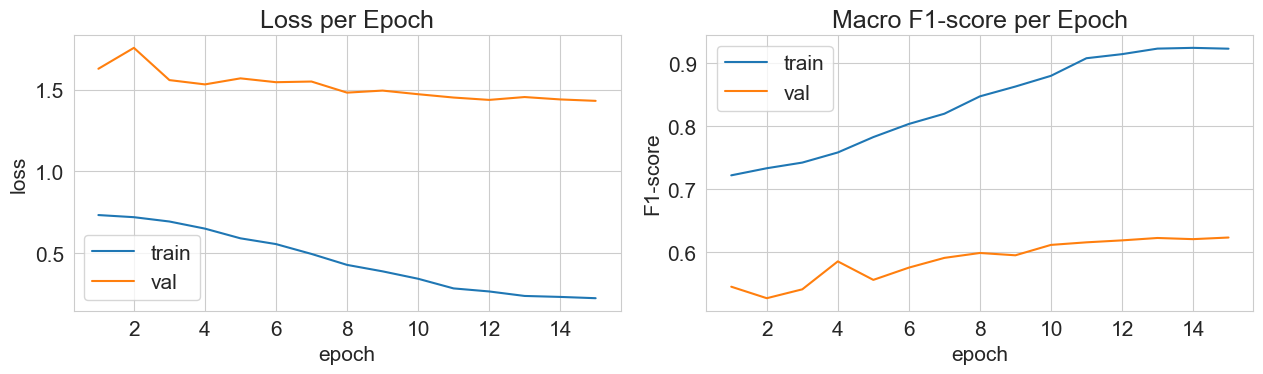

In [31]:
num_epochs = 15

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train_losses, val_losses, train_f1s, val_f1s = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_epochs=num_epochs
)

In [32]:
img_ids, predictions = predict(model, test_loader, device)

ids = [int(name.split('.')[0]) for name in img_ids]

submission = pd.DataFrame({
    "id": ids,
    "target_feature": predictions
}).sort_values("id")

submission.to_csv("submission.csv", index=False)

Predicting: 100%|██████████| 83/83 [00:19<00:00,  4.16it/s]


# Все сабмит и бэзлайн на этом закончен))))

In [40]:
model = MobileNetV2(n_class=19).to(device)

In [41]:
model.load_state_dict(torch.load("best_model_by_f1.pth", map_location=device))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
       

In [42]:
img_ids, predictions = predict(model, test_loader, device)

ids = [int(name.split('.')[0]) for name in img_ids]

submission = pd.DataFrame({
    "id": ids,
    "target_feature": predictions
}).sort_values("id")

submission.to_csv("submission.csv", index=False)

Predicting: 100%|██████████| 83/83 [00:20<00:00,  4.00it/s]
